In [1]:
import warnings

warnings.filterwarnings("ignore")

import sys
import os

# 配置搜索路径
sys.path.append("./")
sys.path.append("../")
sys.path.append("../../")
import backtrader as bt
import pandas as pd
import numpy as np
import pprint
import sqlite3
import math
from tqdm import tqdm
from datetime import datetime
from Offline.strategies.ml_based_strategy_latest_回归策略 import CustomMLStrategy
from backtest_utils import CustomCommissionSchema, CustomAnalyzer
from Share.database.downloader.downloader_base import DownloaderBase
import Share.database.database_config as db_config

In [2]:
BACKTEST_INDEX_SYMBOLS = "000016"  # 【选股】策略的对比基准=指数index，【择时】策略的对比基准=单股自身
# ---- 回归任务
model_pred_df = pd.read_pickle(f'./backtest_data/test/{BACKTEST_INDEX_SYMBOLS}_20190101_回归任务_v2.pkl')

In [3]:
# 构建数据里表
BACKTEST_STOCK_SYMBOLS = model_pred_df['stock_code'].unique().tolist()
BACKTEST_START_DATE = datetime.strptime(model_pred_df['datetime'].min(), "%Y-%m-%d").strftime("%Y%m%d")  # 回测开始日期
BACKTEST_END_DATE = datetime.strptime(model_pred_df['datetime'].max(), "%Y-%m-%d").strftime("%Y%m%d")  # 回测结束日期
print(f'Start: {BACKTEST_START_DATE}, End: {BACKTEST_END_DATE}')
BACKTEST_DATETIME_INDEX = pd.date_range(start=BACKTEST_START_DATE, end=BACKTEST_END_DATE, freq='B')

Start: 20190102, End: 20231207


In [4]:
# 初始化db_downloader
db_conn = sqlite3.connect("../../Share/database/hh_quant.db")
db_downloader = DownloaderBase(db_conn=db_conn, db_config=db_config)
# 初始化backtrader相关参数
cerebro = bt.Cerebro()
BACKTEST_INITIAL_CASH = 100000  # 初始化资金

print("开始设置回测基础参数...")
cerebro.broker.setcash(BACKTEST_INITIAL_CASH)  # 配置初始资金量
cerebro.broker.addcommissioninfo(CustomCommissionSchema())  # 配置自定义的佣金类型
cerebro.broker.set_slippage_perc(perc=0.0001) # 配置自定义的滑点类型

print("开始添加回测股票数据...")
for stock_symbol in tqdm(BACKTEST_STOCK_SYMBOLS):
    stock_data = db_downloader._download_stock_history_info(stock_symbol, start_date=BACKTEST_START_DATE, end_date=BACKTEST_END_DATE)
    if not stock_data.empty:
        stock_data = stock_data[["datetime", "open", "high", "low", "close", "volume"]]
        stock_data["datetime"] = pd.to_datetime(stock_data["datetime"])
        stock_data = stock_data.set_index("datetime").reindex(BACKTEST_DATETIME_INDEX).fillna(method='ffill')
        stock_data_feeds = bt.feeds.PandasData(dataname=stock_data)  # 构建回测数据Feeds流
        cerebro.adddata(stock_data_feeds, name=stock_symbol)  # 添加回测数据

print("开始添加基准数据...")
benchmark_data = db_downloader._download_index_history_info(BACKTEST_INDEX_SYMBOLS, start_date=BACKTEST_START_DATE, end_date=BACKTEST_END_DATE)
benchmark_data = benchmark_data[["datetime", "open", "high", "low", "close", "volume"]]
benchmark_data["datetime"] = pd.to_datetime(benchmark_data["datetime"])
benchmark_data = benchmark_data.set_index("datetime").reindex(BACKTEST_DATETIME_INDEX).fillna(method='ffill')
benchmark_name = f"benchmark_{BACKTEST_INDEX_SYMBOLS}"
benchmark_data_feeds = bt.feeds.PandasData(dataname=benchmark_data)  # 构建基准数据Feeds流
cerebro.adddata(benchmark_data_feeds, name=benchmark_name)  # 添加基准数据

print("开始添加分析器...")
cerebro.addanalyzer(bt.analyzers.DrawDown, _name="drawdown")  # 添加最大回撤的分析器，后续customAnalyzer中需要用到
cerebro.addanalyzer(CustomAnalyzer, _name="custom_analyzer")  # 添加自定义的分析器

# print("开始添加观察器...")
# cerebro.addobserver(bt.observers.Benchmark, data=benchmark_data_feeds, timeframe=bt.TimeFrame.NoTimeFrame)  # 添加基准对比观察器

开始设置回测基础参数...
开始添加回测股票数据...


100%|██████████| 50/50 [00:00<00:00, 181.87it/s]

开始添加基准数据...
开始添加分析器...


In [5]:
print("开始添加策略...")
strategy_params = {
    "benchmark": benchmark_name,
    "model_pred_dataframe": model_pred_df,
}

lower_bound, upper_boumd = np.nanquantile(model_pred_df['label_pred'], [0.2, 0.8])

strategy_params.update(
    {
        "max_position_proportion": 0.15,  # 最大持仓资金占比
        "min_holding_period": 3,  # 最小持仓周期
        "max_holding_period": 20,  # 最大持仓周期
        "top_n": 5,  # 每日选择股票的TopN
        "min_buy_cash": 2000,  # 最小购买资金限制
        "atr_period": 14,  # ATR计算周期
        "atr_trailing_stop_loss_factor": 1.5,  # ATR跟踪止损
        "atr_risk": 0.05,  # ATR风险系数
        "buy_pred_upper_bound": upper_boumd,
        "sell_pred_lower_bound": lower_bound
    }
)

cerebro.addstrategy(CustomMLStrategy, **strategy_params)

开始添加策略...


0

In [6]:
print("开始运行回测...")
# 运行回测
results = cerebro.run()
# 打印初始资金
print(f"Start Portfolio Value: {BACKTEST_INITIAL_CASH}")
# 打印最终资金
print(f"Final Portfolio Value: {cerebro.broker.getvalue()}")

开始运行回测...
启动基准对比...
回测数据共: 50
current_date: 2019-01-02 ================================================================================
current_cash: 100000.0
2019-01-03 买入执行, 引用: 1, 价格: 33.12, 成本: 14968.93, 手续费: 5.00, 数量: 452.00, 股票: 600150
2019-01-03 买入执行, 引用: 2, 价格: 66.83, 成本: 14969.18, 手续费: 5.00, 数量: 224.00, 股票: 600893
2019-01-03 买入执行, 引用: 3, 价格: 4.26, 成本: 10408.77, 手续费: 5.00, 数量: 2446.00, 股票: 601919
2019-01-03 买入执行, 引用: 4, 价格: 213.14, 成本: 14706.55, 手续费: 5.00, 数量: 69.00, 股票: 600089
2019-01-03 买入执行, 引用: 5, 价格: 19.62, 成本: 5218.67, 手续费: 5.00, 数量: 266.00, 股票: 601633
current_date: 2019-01-03 ================================================================================
current_cash: 39702.897292390015
2019-01-04 买入执行, 引用: 6, 价格: 129.35, 成本: 7890.21, 手续费: 5.00, 数量: 61.00, 股票: 600111
2019-01-04 买入执行, 引用: 7, 价格: 39.14, 成本: 7828.86, 手续费: 5.00, 数量: 200.00, 股票: 600900
2019-01-04 买入执行, 引用: 8, 价格: 19.34, 成本: 2688.15, 手续费: 5.00, 数量: 139.00, 股票: 601633
current_date: 2019-01-04 =================

开始打印回测相关指标...
Start Portfolio Value: 100000
Final Portfolio Value: 361567.6619102178
{'其他': {'亏损次数': 621,
        '夏普比率': 1.4383,
        '日均超额收益': 0.001,
        '日胜率': 0.4984,
        '最大回撤': 20.8223,
        '最大回撤区间': 153,
        '盈亏比': 1.9567,
        '盈利次数': 516,
        '索提诺比率': 2.1634,
        '胜率': 0.4538,
        '贝塔': 0.6999,
        '超额收益': 2.6104,
        '超额收益夏普比率': 1.7258,
        '阿尔法': 0.001},
 '基准': {'基准年化收益': 0.001, '基准收益': 0.0053, '基准波动率': 0.1868},
 '策略': {'策略年化收益': 0.2862, '策略收益': 2.6157, '策略波动率': 0.1874}}


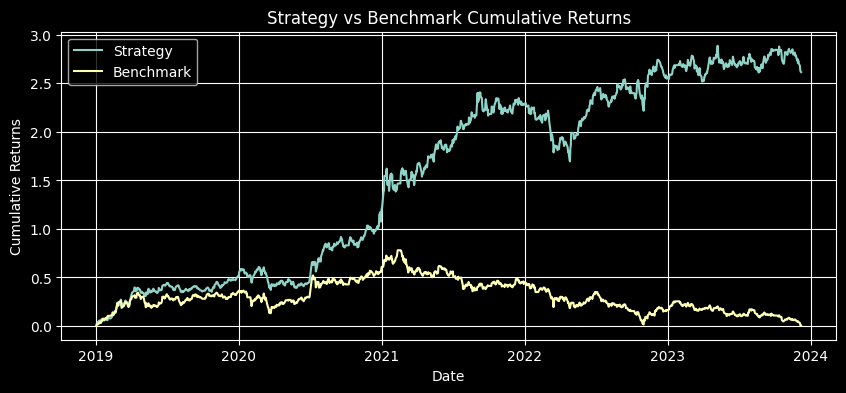

In [7]:
print("开始打印回测相关指标...")
# 打印初始资金
print(f"Start Portfolio Value: {BACKTEST_INITIAL_CASH}")
# 打印最终资金
print(f"Final Portfolio Value: {cerebro.broker.get_value()}")

def plot_strategy_benchmark_returns(strategy_returns, benchmark_returns):
    import matplotlib.pyplot as plt
    # 检查index是否一致以保证对齐
    if not strategy_returns.index.equals(benchmark_returns.index):
        raise ValueError("Indexes of strategy_returns and benchmark_returns must match")
    # 计算累积收益率
    strategy_cumulative_returns = (1 + strategy_returns).cumprod() - 1
    benchmark_cumulative_returns = (1 + benchmark_returns).cumprod() - 1
    # 绘制累积收益率曲线
    plt.figure(figsize=(10,4))
    plt.plot(strategy_cumulative_returns, label='Strategy')
    plt.plot(benchmark_cumulative_returns, label='Benchmark')
    # 添加标题和标签
    plt.title('Strategy vs Benchmark Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    # 显示图例
    plt.legend()
    # 显示网格
    plt.grid(True)
    # 显示绘制的图形
    plt.show()

custom_analysis = results[0].analyzers.custom_analyzer.get_analysis()
format_analysis_result = {"基准": {}, "策略": {}, "其他": {}}
for key, value in custom_analysis.items():
    if key.startswith("基准"):
        format_analysis_result["基准"][key] = round(value, 4)
    elif key.startswith("策略"):
        format_analysis_result["策略"][key] = round(value, 4)
    else:
        format_analysis_result["其他"][key] = round(value, 4)
pprint.pprint(format_analysis_result)

strategy_returns = pd.Series(results[0].analyzers.custom_analyzer.get_strategy_returns(), index=benchmark_data.index[1:])
benchmark_returns = pd.Series(results[0].analyzers.custom_analyzer.get_benchmark_returns(), index=benchmark_data.index[1:])
plot_strategy_benchmark_returns(strategy_returns, benchmark_returns)

In [8]:
# #####################最小持仓周期0
# 开始打印回测相关指标...
# Start Portfolio Value: 100000
# Final Portfolio Value: 338881.5555567004
# {'其他': {'亏损次数': 879,
#         '夏普比率': 1.4033,
#         '日均超额收益': 0.0009,
#         '日胜率': 0.5008,
#         '最大回撤': 22.9176,
#         '最大回撤区间': 153,
#         '盈亏比': 2.3703,
#         '盈利次数': 591,
#         '索提诺比率': 2.0965,
#         '胜率': 0.402,
#         '贝塔': 0.6752,
#         '超额收益': 2.3835,
#         '超额收益夏普比率': 1.6373,
#         '阿尔法': 0.001},
#  '基准': {'基准年化收益': 0.001, '基准收益': 0.0053, '基准波动率': 0.1868},
#  '策略': {'策略年化收益': 0.2699, '策略收益': 2.3888, '策略波动率': 0.1823}}

# #####################最小持仓周期3
#  开始打印回测相关指标...
# Start Portfolio Value: 100000
# Final Portfolio Value: 349034.9783879757
# {'其他': {'亏损次数': 741,
#         '夏普比率': 1.4178,
#         '日均超额收益': 0.001,
#         '日胜率': 0.4992,
#         '最大回撤': 20.6306,
#         '最大回撤区间': 153,
#         '盈亏比': 2.0969,
#         '盈利次数': 564,
#         '索提诺比率': 2.1132,
#         '胜率': 0.4322,
#         '贝塔': 0.6821,
#         '超额收益': 2.485,
#         '超额收益夏普比率': 1.6627,
#         '阿尔法': 0.001},
#  '基准': {'基准年化收益': 0.001, '基准收益': 0.0053, '基准波动率': 0.1868},
#  '策略': {'策略年化收益': 0.2773, '策略收益': 2.4903, '策略波动率': 0.1849}}


In [9]:
annual_strategy_returns = strategy_returns.resample('Y').apply(lambda x: (1 + x).prod() - 1)
annual_benchmark_returns = benchmark_returns.resample('Y').apply(lambda x: (1 + x).prod() - 1)
annual_returns = pd.concat([annual_strategy_returns, annual_benchmark_returns], axis=1)
annual_returns.columns = ['Strategy', 'Benchmark']
annual_returns['Gap'] = annual_returns['Strategy'] - annual_returns['Benchmark']
annual_returns

,Strategy,Benchmark,Gap
2019-12-31,0.510187,0.353735,0.156452
2020-12-31,0.464046,0.188501,0.275545
2021-12-31,0.488693,-0.100619,0.589312
2022-12-31,0.083000,-0.195177,0.278177
2023-12-31,0.014309,-0.136769,0.151078


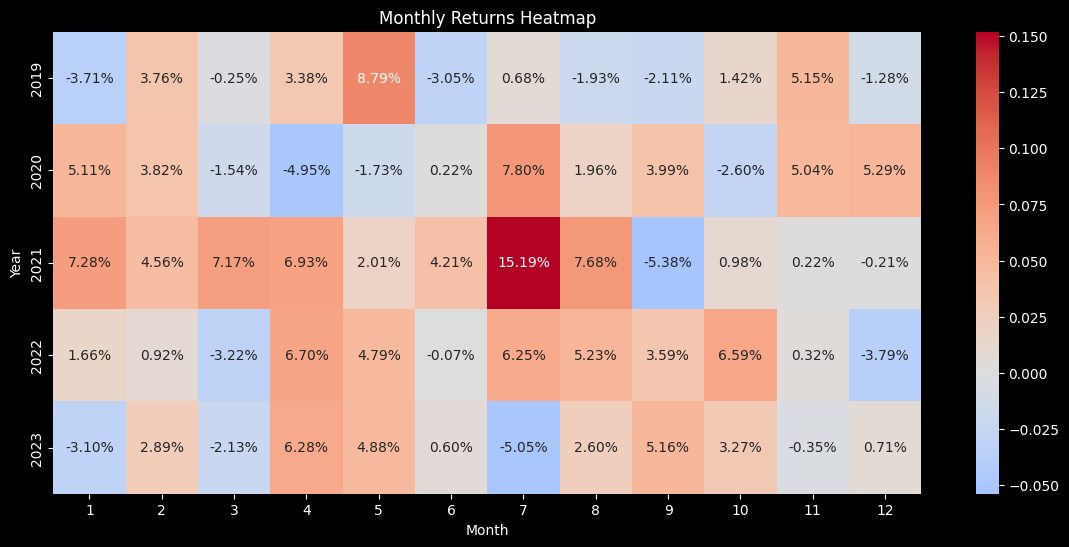

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 monthly_returns 是一个包含月度收益率的Series，并且它的索引是DateTimeIndex
# 如果它不是DataFrame，我们先将其转换成DataFrame
strategy_monthly_returns = strategy_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
benchmark_monthly_returns = benchmark_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
gap_monthly = strategy_monthly_returns - benchmark_monthly_returns

monthly_returns_df = gap_monthly.to_frame(name='收益率差')

# 创建新的列来代表年份和月份
monthly_returns_df['Year'] = monthly_returns_df.index.year
monthly_returns_df['Month'] = monthly_returns_df.index.month

# 使用pivot方法来创建适合热力图的DataFrame
pivot_table = monthly_returns_df.pivot(index='Year', columns='Month', values='收益率差')

# 使用Seaborn绘制热力图
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2%",cmap='coolwarm', center=0)
plt.title('Monthly Returns Heatmap')
plt.ylabel('Year')
plt.xlabel('Month')
plt.show()


In [11]:
# !nvidia-smi

In [12]:
import pandas as pd
import numpy as np

In [13]:
# def get_stock_for_buy(group):
#     top_n = group.nlargest(3, "label_pred")
#     return top_n.to_dict("records")

# def get_stock_for_sell(group):
#     top_n = group.nsmallest(3, "label_pred")
#     return top_n.to_dict("records")

# model_prediction = pd.read_pickle('./backtest_data/test/000016_20190101_回归任务.pkl')
# stock_for_buy = model_prediction.groupby("datetime").apply(get_stock_for_buy).to_dict()
# stock_for_sell = model_prediction.groupby("datetime").apply(get_stock_for_sell).to_dict()